# Clausal Analysis 2
## Slot Membership Analysis for בַּיּוֹם הַהוּא

In [1]:
import random
import sys
import pickle
import json
import collections
import pandas as pd
import numpy as np
from pathlib import Path
from bidi import algorithm
from textwrap import dedent
import matplotlib.pyplot as plt
import seaborn as sns

from tf.fabric import Fabric
from tf.app import use

PAIRS = "pairs.pkl"

from kingham_thesis.paths import paths
from kingham_thesis.stats.significance import apply_deltaP, apply_fishers
from kingham_thesis.visualization.plotting import heatmap

In [2]:
PARSE_DATA = paths['phrase_parses']
with open(PARSE_DATA, 'r') as infile:
    phrase_parsings = json.load(infile)

In [3]:
TF = Fabric(
    locations=['/Users/cody/github/etcbc/bhsa/tf/c',
               '/Users/cody/github/etcbc/genre_synvar/tf/c'], 
    silent='deep',
)


API = TF.load(
    'kind lex vt pdp ls '
    'lex_utf8 nu code rela '
    'prs prs_gn prs_nu prs_ps '
    'genre mother txt uvf typ '
    'g_prs_utf8 sp vs typ '
    'voc_lex_utf8 '
    'label gloss function number '
    'language '
)

In [4]:
bhsa = use('etcbc/bhsa', backend=None, api=API)
F, E, T, L = (getattr(bhsa.api, method) for method in "FETL")

**Locating corpus resources ...**

Name,# of nodes,# slots/node,% coverage
book,39,10938.05,100
chapter,929,459.19,100
lex,9233,46.20,100
verse,23213,18.38,100
half_verse,45180,9.44,100
sentence,63727,6.69,100
sentence_atom,64525,6.61,100
clause,88121,4.84,100
clause_atom,90688,4.70,100
phrase,253207,1.68,100


# Build Common Sets

In [5]:
RESULT_PLOT_DIR = Path("/Users/cody/Library/Mobile Documents/com~apple~CloudDocs/dissertation/cx_pilot_2022/result_plots")
EXPORT_NEW_PLOTS = False

def format_plot_fname(name):
    fname = f'{name}.pdf' if not name.endswith('.pdf') else name
    return RESULT_PLOT_DIR.joinpath(fname)

In [6]:
def is_no_gaps(slots):
    """Check for slot gaps in an BHSA object."""
    prev_slot = slots[0]
    for slot in slots[1:]:
        if slot - prev_slot != 1:
            return False
        prev_slot = slot
    return True

### Define Custom Sets

Custom sets will be used to assign labels to the data

In [7]:
custom_sets = {}

# define target clauses
custom_sets["target_cl"] = bhsa.search("""

clause kind=VC

""", shallow=True)

print('\tbefore cl filter', len(custom_sets["target_cl"]))
custom_sets["target_cl"] = set(
    cl for cl in custom_sets["target_cl"] if is_no_gaps(L.d(cl, 'word'))
)
print('\tafter cl filter', len(custom_sets["target_cl"]))


custom_sets["gapless_cl"] = bhsa.search('clause', shallow=True)

custom_sets["gapless_cl"] = set(
    cl for cl in custom_sets["gapless_cl"] if is_no_gaps(L.d(cl, 'word'))
)


# define simple, noun-based phrases
custom_sets["target_slot"] = bhsa.search("""

phrase function=Adju|Time|Loca|Objc|Subj|Cmpl
/without/
    word lex=W
/-/
/without/
    word sp=advb
/-/
/with/
    word pdp=subs
/-/
    =: word
    <: word

""", shallow=True)


# define predicate phrase
custom_sets["predicate"] = bhsa.search("""

phrase function=Pred|PreO|PreS
    word vt=perf|impf

""", shallow=True)

  0.05s 68578 results
	before cl filter 68578
	after cl filter 66523
  0.01s 88121 results
  1.12s 47403 results
  0.34s 37227 results


In [8]:
prec_particle_clauses = bhsa.search("""

clause
    =: phrase function=Conj|IntJ|Rela|Ques

""")

prec_particle_clauses = {result[0]: result for result in prec_particle_clauses}

  0.29s 52917 results


## Function for getting row data

In [9]:
def flatten_results(results, result_index=0):
    """Reduce results list to a set."""
    return set(
        result[result_index] for result in results
    )

def get_generic_data(
        clause_node,
        target_ph,
):
    """Generate generic row data."""
    book, chapter, verse = T.sectionFromNode(clause_node)
    ref = f'{book} {chapter}:{verse}'
    cl_text = T.text(clause_node)
    target_ph_text = T.text(target_ph)
    return {
        'cl_node': clause_node,
        'ref': ref,
        'book': book,
        'cl_text': cl_text,
        'target_ph': target_ph_text,
    }

def get_rows_from_data(
        results,     # list of BHSA search results
        set_dict,    # dict mapping result sets
        cl_tag,      # string to tag these clauses by
        cl_index,    # results index of the clause element
        verb_index,  # results index of the verb element 
        x_index,     # results index of the "X" element
        prep_index,
        head_index,
        appo_index,
):
    """Collect data from a sample of clauses into rows."""
    rows = []
    for result in results:
        row = get_generic_data(result[0], result[x_index])
        row['clause_type'] = cl_tag
        clause = result[cl_index]
        verb = result[verb_index]
        verse = L.u(verb, 'verse')[0]
        row['genre'] = F.genre.v(verse)
        row['verse_text'] = T.text(verse)
        x_phrase = result[x_index]
        if F.language.v(verb) != 'Hebrew':
            continue
        row['verb_text'] = T.text(verb)
        row['verb_lex'] = F.lex.v(verb)
        row['verb_type'] = F.vt.v(verb)
        row['verb_stem'] = F.vs.v(verb)
        row['xphrase_function'] = F.function.v(x_phrase)
        row['cl_front'] = None
        if clause in prec_particle_clauses:
            prec_part_ph = prec_particle_clauses[clause][1]
            prec_lex = '_'.join(F.lex.v(w) for w in L.d(prec_part_ph, 'word'))
            row['cl_front'] = prec_lex

        row['slot_prep'] = '?'
        for name, results in set_dict.items():
            row[name] = 0
            row['slot_is_bayomhahu'] = 0
            if clause in results:
                row[name] = 1
                if name == 'slot_is_def_appo':
                    prep_slot = results[clause][prep_index]
                    head_slot = results[clause][head_index]
                    appo_slot = results[clause][appo_index]
                    row['slot_prep'] = F.lex.v(prep_slot)
                    row['slot_def_appo_head_lex'] = F.lex.v(head_slot)
                    row['slot_def_appo_appo_pdp'] = F.pdp.v(appo_slot)
                    row['slot_def_appo_appo_lex'] = F.lex.v(appo_slot)
                    if (
                            row['slot_def_appo_head_lex'] == 'JWM/' 
                            and row['slot_def_appo_appo_lex'] == 'HW>'
                            and row['slot_prep'] == 'B'
                    ):
                        row['slot_is_bayomhahu'] = 1                        

        rows.append(row)
    return rows

# (X+clause) samples

In [10]:
result_set = {}

In [11]:
x_clause = bhsa.search("""

target_cl
    =1: target_slot typ=NP|PP
    < predicate
        word vt=perf|impf

""", sets=custom_sets)

  0.39s 4832 results


In [12]:
# bhsa.show(x_clause)

In [13]:
PP_clause = bhsa.search("""

target_cl
    =1: target_slot typ=PP
        =: word pdp=prep
    < predicate

""", sets=custom_sets)

result_set['slot_is_PP'] = {result[0]: result for result in PP_clause}

  0.40s 2802 results


In [14]:
B_clause = bhsa.search("""

target_cl
    =1: target_slot
        =: word lex=B
    < predicate

""", sets=custom_sets)

result_set['slot_is_B'] = {result[0]: result for result in B_clause}

  0.34s 1049 results


In [15]:
BH_clause = bhsa.search("""

target_cl
    =1: target_slot
        =: word lex=B
        <: word lex=H
        <: word
    < predicate

""", sets=custom_sets)

result_set['slot_is_BH'] = {result[0]: result for result in BH_clause}

  0.67s 306 results


In [16]:
def_appo_clause = bhsa.search("""

target_cl
    =1: target_slot
        =: word pdp=prep
        <: word lex=H
        <: word
        <: word lex=H
        <: word
    < predicate

""", sets=custom_sets)

result_set['slot_is_def_appo'] = {result[0]: result for result in def_appo_clause}

  1.00s 178 results


In [17]:
# bhsa.show(
#     cl_with_x,
#     condenseType='clause',
#     extraFeatures='function',
#     withNodes=True,
# )

In [18]:
x_cl_rows = get_rows_from_data(
    results=x_clause,
    set_dict=result_set,
    cl_tag='x_clause',
    cl_index=0,
    verb_index=3,
    x_index=1,
    prep_index=2,
    head_index=4,
    appo_index=6,
)

len(x_cl_rows)

4726

In [19]:
x_cl_rows[0]

{'cl_node': 427553,
 'ref': 'Genesis 1:1',
 'book': 'Genesis',
 'cl_text': 'בְּרֵאשִׁ֖ית בָּרָ֣א אֱלֹהִ֑ים אֵ֥ת הַשָּׁמַ֖יִם וְאֵ֥ת הָאָֽרֶץ׃ ',
 'target_ph': 'בְּרֵאשִׁ֖ית ',
 'clause_type': 'x_clause',
 'genre': 'prose',
 'verse_text': 'בְּרֵאשִׁ֖ית בָּרָ֣א אֱלֹהִ֑ים אֵ֥ת הַשָּׁמַ֖יִם וְאֵ֥ת הָאָֽרֶץ׃ ',
 'verb_text': 'בָּרָ֣א ',
 'verb_lex': 'BR>[',
 'verb_type': 'perf',
 'verb_stem': 'qal',
 'xphrase_function': 'Time',
 'cl_front': None,
 'slot_prep': '?',
 'slot_is_PP': 1,
 'slot_is_bayomhahu': 0,
 'slot_is_B': 1,
 'slot_is_BH': 0,
 'slot_is_def_appo': 0}

# (Clause+X) samples

In [20]:
clause_x = bhsa.search("""

cl:target_cl
/without/
    phrase function=Adju|Time|Loca
    < phrase function=Objc|Cmpl|Subj
/-/
/without/
    phrase function=Adju|Time|Loca|Objc|Cmpl|Subj
    < phrase function=Pred|PreO|PreS
/-/
    phrase function=Pred|PreO|PreS
        w:word pdp=verb vt=wayq|perf|impf
        /without/
        w lex=HJH[ vt=wayq nu=sg ps=p3
        /-/
        /without/
        word lex=W
        <: w lex=HJH[ vt=perf nu=sg ps=p3
        /-/

    < targ:target_slot function=Time|Adju|Loca|Subj|Objc|Cmpl
        =: word
        <: word

cl := targ

""", sets=custom_sets)

custom_sets['ending_ph'] = set(result[3] for result in clause_x)

  1.27s 15238 results


In [21]:
clause_x_results = {}

In [22]:
clause_PP = bhsa.search("""

clause
    ending_ph typ=PP

""", sets=custom_sets)

clause_x_results['slot_is_PP'] = {res[0]: res for res in clause_PP}

  0.05s 11411 results


In [23]:
clause_B = bhsa.search("""

clause
    ending_ph
        =: word lex=B

""", sets=custom_sets)

clause_x_results['slot_is_B'] = {res[0]: res for res in clause_B}

  0.22s 3159 results


In [24]:
clause_BH = bhsa.search("""

clause
    ending_ph
        =: word lex=B
        <: word lex=H

""", sets=custom_sets)

clause_x_results['slot_is_BH'] = {res[0]: res for res in clause_BH}

  0.39s 935 results


In [25]:
clause_def_appo = bhsa.search("""

clause
    ending_ph
        =: word pdp=prep
        <: word lex=H
        <: word
        <: word lex=H
        <: word

""", sets=custom_sets)

clause_x_results['slot_is_def_appo'] = {res[0]: res for res in clause_def_appo}

  0.89s 437 results


In [26]:
# bhsa.show(
#     random.sample(clause_x, 100),
#     condenseType='clause',
#     withNodes=True,
#     extraFeatures='function',
# )

In [27]:
cl_x_rows = get_rows_from_data(
    results=clause_x,
    set_dict=clause_x_results,
    cl_tag='clause_x',
    cl_index=0,
    verb_index=2,
    x_index=3,
    prep_index=2,
    head_index=4,
    appo_index=6,
)

In [28]:
len(cl_x_rows)

15135

In [29]:
cl_x_rows[0]

{'cl_node': 427560,
 'ref': 'Genesis 1:4',
 'book': 'Genesis',
 'cl_text': 'וַיַּ֧רְא אֱלֹהִ֛ים אֶת־הָאֹ֖ור ',
 'target_ph': 'אֶת־הָאֹ֖ור ',
 'clause_type': 'clause_x',
 'genre': 'prose',
 'verse_text': 'וַיַּ֧רְא אֱלֹהִ֛ים אֶת־הָאֹ֖ור כִּי־טֹ֑וב וַיַּבְדֵּ֣ל אֱלֹהִ֔ים בֵּ֥ין הָאֹ֖ור וּבֵ֥ין הַחֹֽשֶׁךְ׃ ',
 'verb_text': 'יַּ֧רְא ',
 'verb_lex': 'R>H[',
 'verb_type': 'wayq',
 'verb_stem': 'qal',
 'xphrase_function': 'Objc',
 'cl_front': 'W',
 'slot_prep': '?',
 'slot_is_PP': 1,
 'slot_is_bayomhahu': 0,
 'slot_is_B': 0,
 'slot_is_BH': 0,
 'slot_is_def_appo': 0}

# Medial Adjunct Construction

In [30]:
medial_adjunct = bhsa.search("""

target_cl
    predicate
        word vt=perf|impf
    < target_slot function=Time|Loca|Adju
    < phrase function=Objc|Cmpl|Subj

""", sets=custom_sets)

  0.44s 490 results


In [31]:
medial_adj_results = {}

In [32]:
medial_adjunct_PP = bhsa.search("""

target_cl
    predicate
    < target_slot function=Time|Loca|Adju typ=PP
    < phrase function=Objc|Cmpl|Subj

""", sets=custom_sets)

medial_adj_results['slot_is_PP'] = {res[0]: res for res in medial_adjunct_PP}

  0.24s 440 results


In [33]:
medial_adjunct_B = bhsa.search("""

target_cl
    predicate
    < target_slot function=Time|Loca|Adju typ=PP
        =: word lex=B
    < phrase function=Objc|Cmpl|Subj

""", sets=custom_sets)

medial_adj_results['slot_is_B'] = {res[0]: res for res in medial_adjunct_B}

  0.43s 196 results


In [34]:
medial_adjunct_BH = bhsa.search("""

target_cl
    predicate
    < target_slot function=Time|Loca|Adju typ=PP
        =: word lex=B
        <: word lex=H
    < phrase function=Objc|Cmpl|Subj

""", sets=custom_sets)

medial_adj_results['slot_is_BH'] = {res[0]: res for res in medial_adjunct_BH}

  0.62s 71 results


In [35]:
medial_adjunct_B_def_appo = bhsa.search("""

target_cl
    predicate
    < target_slot function=Time|Loca|Adju
        =: word pdp=prep
        <: word lex=H
        <: word
        <: word lex=H
        <: word
    < phrase function=Objc|Cmpl|Subj

""", sets=custom_sets)

medial_adj_results['slot_is_def_appo'] = {res[0]: res for res in medial_adjunct_B_def_appo}

  1.19s 15 results


In [36]:
# bhsa.show(
#     random.sample(medial_adjunct, 50),
#     condenseType='clause',
#     withNodes=True,
#     end=25,
# )

In [37]:
medial_adj_rows = get_rows_from_data(
    results=medial_adjunct,
    set_dict=medial_adj_results,
    cl_tag='medial_adj',
    cl_index=0,
    verb_index=2,
    x_index=3,
    prep_index=3,
    head_index=5,
    appo_index=7,
)

In [38]:
len(medial_adj_rows)

488

In [39]:
medial_adj_rows[0]

{'cl_node': 427927,
 'ref': 'Genesis 4:14',
 'book': 'Genesis',
 'cl_text': 'הֵן֩ גֵּרַ֨שְׁתָּ אֹתִ֜י הַיֹּ֗ום מֵעַל֙ פְּנֵ֣י הָֽאֲדָמָ֔ה ',
 'target_ph': 'הַיֹּ֗ום ',
 'clause_type': 'medial_adj',
 'genre': 'prose',
 'verse_text': 'הֵן֩ גֵּרַ֨שְׁתָּ אֹתִ֜י הַיֹּ֗ום מֵעַל֙ פְּנֵ֣י הָֽאֲדָמָ֔ה וּמִפָּנֶ֖יךָ אֶסָּתֵ֑ר וְהָיִ֜יתִי נָ֤ע וָנָד֙ בָּאָ֔רֶץ וְהָיָ֥ה כָל־מֹצְאִ֖י יַֽהַרְגֵֽנִי׃ ',
 'verb_text': 'גֵּרַ֨שְׁתָּ ',
 'verb_lex': 'GRC[',
 'verb_type': 'perf',
 'verb_stem': 'piel',
 'xphrase_function': 'Time',
 'cl_front': None,
 'slot_prep': '?',
 'slot_is_PP': 0,
 'slot_is_bayomhahu': 0,
 'slot_is_B': 0,
 'slot_is_BH': 0,
 'slot_is_def_appo': 0}

# (wayyehi + X)

In [40]:
wayehi_x = bhsa.search("""

clause
    =: word lex=W
    <: word vt=wayq lex=HJH[ ps=p3 gn=m nu=sg
    <: phrase function=Adju|Time|Loca|Objc|Cmpl|Subj
        =: word
        <: word

""")

  0.96s 345 results


In [41]:
wayehi_x_results = {}

In [42]:
wayehi_B = bhsa.search("""

clause
    =: word lex=W
    <: word vt=wayq lex=HJH[ ps=p3 gn=m nu=sg
    <: phrase function=Adju|Time|Loca|Objc|Cmpl|Subj typ=PP
        =: word
        <: word

""")

wayehi_x_results['slot_is_PP'] = {res[0]: res for res in wayehi_B}

  0.94s 173 results


In [43]:
wayehi_B = bhsa.search("""

clause
    =: word lex=W
    <: word vt=wayq lex=HJH[ ps=p3 gn=m nu=sg
    <: phrase function=Adju|Time|Loca|Objc|Cmpl|Subj
        =: word lex=B
        <: word

""")

wayehi_x_results['slot_is_B'] = {res[0]: res for res in wayehi_B}

  0.90s 88 results


In [44]:
wayehi_B_H = bhsa.search("""

clause
    =: word lex=W
    <: word vt=wayq lex=HJH[ ps=p3 gn=m nu=sg
    <: phrase function=Adju|Time|Loca|Objc|Cmpl|Subj
        =: word lex=B
        <: word lex=H

""")

wayehi_x_results['slot_is_BH'] = {res[0]: res for res in wayehi_B_H}

  0.91s 56 results


In [45]:
wayehi_def_appo = bhsa.search("""

clause
    =: word lex=W
    <: word vt=wayq lex=HJH[ ps=p3 gn=m nu=sg
    <: phrase function=Adju|Time|Loca|Objc|Cmpl|Subj
        =: word pdp=prep
        <: word lex=H
        <: word
        <: word lex=H
        <: word

""")

wayehi_x_results['slot_is_def_appo'] = {res[0]: res for res in wayehi_def_appo}

  1.38s 54 results


In [46]:
# bhsa.show(
#     random.sample(wayehi_B, 50),
#     condenseType='clause',
#     extraFeatures='function',
#     withNodes=True,
#     end=25,
# )

In [47]:
wayehi_x_rows = get_rows_from_data(
    results=wayehi_x,
    set_dict=wayehi_x_results,
    cl_tag='wayehi_x',
    cl_index=0,
    verb_index=2,
    x_index=3,
    prep_index=4,
    head_index=6,
    appo_index=8,
)

In [48]:
len(wayehi_x_rows)

345

In [49]:
wayehi_x_rows[0]

{'cl_node': 427702,
 'ref': 'Genesis 2:7',
 'book': 'Genesis',
 'cl_text': 'וַֽיְהִ֥י הָֽאָדָ֖ם לְנֶ֥פֶשׁ חַיָּֽה׃ ',
 'target_ph': 'הָֽאָדָ֖ם ',
 'clause_type': 'wayehi_x',
 'genre': 'prose',
 'verse_text': 'וַיִּיצֶר֩ יְהוָ֨ה אֱלֹהִ֜ים אֶת־הָֽאָדָ֗ם עָפָר֙ מִן־הָ֣אֲדָמָ֔ה וַיִּפַּ֥ח בְּאַפָּ֖יו נִשְׁמַ֣ת חַיִּ֑ים וַֽיְהִ֥י הָֽאָדָ֖ם לְנֶ֥פֶשׁ חַיָּֽה׃ ',
 'verb_text': 'יְהִ֥י ',
 'verb_lex': 'HJH[',
 'verb_type': 'wayq',
 'verb_stem': 'qal',
 'xphrase_function': 'Subj',
 'cl_front': 'W',
 'slot_prep': '?',
 'slot_is_PP': 0,
 'slot_is_bayomhahu': 0,
 'slot_is_B': 0,
 'slot_is_BH': 0,
 'slot_is_def_appo': 0}

# (wehaya + X)

In [50]:
wehaya_x = bhsa.search("""

clause
    =: word lex=W
    <: word vt=perf lex=HJH[ ps=p3 gn=m nu=sg
    <: phrase function=Adju|Time|Loca|Objc|Cmpl|Subj
        =: word
        <: word

""")

  0.91s 112 results


In [51]:
wehaya_x_results = {}

In [52]:
wehaya_PP = bhsa.search("""

clause
    =: word lex=W
    <: word vt=perf lex=HJH[ ps=p3 gn=m nu=sg
    <: phrase function=Adju|Time|Loca|Objc|Cmpl|Subj typ=PP
        =: word
        <: word

""")

wehaya_x_results['slot_is_PP'] = {res[0]: res for res in wehaya_PP}

  0.92s 67 results


In [53]:
wehaya_B = bhsa.search("""

clause
    =: word lex=W
    <: word vt=perf lex=HJH[ ps=p3 gn=m nu=sg
    <: phrase function=Adju|Time|Loca|Objc|Cmpl|Subj
        =: word lex=B
        <: word

""")

wehaya_x_results['slot_is_B'] = {res[0]: res for res in wehaya_B}

  0.91s 44 results


In [54]:
wehaya_B_H = bhsa.search("""

clause
    =: word lex=W
    <: word vt=perf lex=HJH[ ps=p3 gn=m nu=sg
    
    <: phrase function=Adju|Time|Loca|Objc|Cmpl|Subj
        =: word lex=B
        <: word lex=H

""")

wehaya_x_results['slot_is_BH'] = {res[0]: res for res in wehaya_B_H}

  0.94s 32 results


In [55]:
wehaya_B_def_appo = bhsa.search("""

clause
    =: word lex=W
    <: word vt=perf lex=HJH[ ps=p3 gn=m nu=sg
    <: phrase function=Adju|Time|Loca|Objc|Cmpl|Subj
        =: word pdp=prep
        <: word lex=H
        <: word
        <: word lex=H
        <: word

""")

wehaya_x_results['slot_is_def_appo'] = {res[0]: res for res in wehaya_B_def_appo}

  1.38s 29 results


In [56]:
# bhsa.show(
#     random.sample(wehaya_x, 25),
#     condenseType='clause',
#     extraFeatures='function',
#     withNodes=True,
#     end=25,
# )

In [57]:
wehaya_x_rows = get_rows_from_data(
    results=wehaya_x,
    set_dict=wehaya_x_results,
    cl_tag='wehaya_x',
    cl_index=0,
    verb_index=2,
    x_index=3,
    prep_index=4,
    head_index=6,
    appo_index=8,
)

In [58]:
len(wehaya_x_rows)

112

# Build Full Table

In [59]:
import itertools

In [60]:
all_rows = list(itertools.chain(*[
    x_cl_rows,
    cl_x_rows,
    medial_adj_rows,
    wayehi_x_rows,
    wehaya_x_rows,
]))

len(all_rows)

20806

In [61]:
df = pd.DataFrame(all_rows)

In [62]:
df.head()

,cl_node,ref,book,cl_text,target_ph,clause_type,genre,verse_text,verb_text,verb_lex,...,cl_front,slot_prep,slot_is_PP,slot_is_bayomhahu,slot_is_B,slot_is_BH,slot_is_def_appo,slot_def_appo_head_lex,slot_def_appo_appo_pdp,slot_def_appo_appo_lex
0,427553,Genesis 1:1,Genesis,בְּרֵאשִׁ֖ית בָּרָ֣א אֱלֹהִ֑ים אֵ֥ת הַשָּׁמַ֖י...,בְּרֵאשִׁ֖ית,x_clause,prose,בְּרֵאשִׁ֖ית בָּרָ֣א אֱלֹהִ֑ים אֵ֥ת הַשָּׁמַ֖י...,בָּרָ֣א,BR>[,...,None,?,1,0,1,0,0,NaN,NaN,NaN
1,427554,Genesis 1:2,Genesis,וְהָאָ֗רֶץ הָיְתָ֥ה תֹ֨הוּ֙ וָבֹ֔הוּ,הָאָ֗רֶץ,x_clause,prose,וְהָאָ֗רֶץ הָיְתָ֥ה תֹ֨הוּ֙ וָבֹ֔הוּ וְחֹ֖שֶׁך...,הָיְתָ֥ה,HJH[,...,W,?,0,0,0,0,0,NaN,NaN,NaN
2,427564,Genesis 1:5,Genesis,וְלַחֹ֖שֶׁךְ קָ֣רָא לָ֑יְלָה,לַחֹ֖שֶׁךְ,x_clause,prose,וַיִּקְרָ֨א אֱלֹהִ֤ים׀ לָאֹור֙ יֹ֔ום וְלַחֹ֖שׁ...,קָ֣רָא,QR>[,...,W,?,1,0,0,0,0,NaN,NaN,NaN
3,427585,Genesis 1:10,Genesis,וּלְמִקְוֵ֥ה הַמַּ֖יִם קָרָ֣א יַמִּ֑ים,לְמִקְוֵ֥ה הַמַּ֖יִם,x_clause,prose,וַיִּקְרָ֨א אֱלֹהִ֤ים׀ לַיַּבָּשָׁה֙ אֶ֔רֶץ וּ...,קָרָ֣א,QR>[,...,W,?,1,0,0,0,0,NaN,NaN,NaN
4,427635,Genesis 1:22,Genesis,וְהָעֹ֖וף יִ֥רֶב בָּאָֽרֶץ׃,הָעֹ֖וף,x_clause,prose,וַיְבָ֧רֶךְ אֹתָ֛ם אֱלֹהִ֖ים לֵאמֹ֑ר פְּר֣וּ ו...,יִ֥רֶב,RBH[,...,W,?,0,0,0,0,0,NaN,NaN,NaN


In [63]:
df.columns

Index(['cl_node', 'ref', 'book', 'cl_text', 'target_ph', 'clause_type',
       'genre', 'verse_text', 'verb_text', 'verb_lex', 'verb_type',
       'verb_stem', 'xphrase_function', 'cl_front', 'slot_prep', 'slot_is_PP',
       'slot_is_bayomhahu', 'slot_is_B', 'slot_is_BH', 'slot_is_def_appo',
       'slot_def_appo_head_lex', 'slot_def_appo_appo_pdp',
       'slot_def_appo_appo_lex'],
      dtype='object')

In [64]:
df.slot_is_bayomhahu.value_counts()

0    20665
1      141
Name: slot_is_bayomhahu, dtype: int64

In [65]:
df.clause_type.value_counts()

clause_x      15135
x_clause       4726
medial_adj      488
wayehi_x        345
wehaya_x        112
Name: clause_type, dtype: int64

In [66]:
df.genre.value_counts()

prose          10064
prophetic       4683
poetry          3333
instruction     2404
list             322
Name: genre, dtype: int64

In [67]:
filter_books = ['Genesis', 'Exodus', 'Leviticus', 'Numbers', 'Deuteronomy', 
                'Joshua', 'Judges', '1_Samuel', '2_Samuel', '1_Kings', '2_Kings',
                'Isaiah', 'Jeremiah', 'Ezekiel', 'Hosea', 'Joel', 'Amos', 'Obadiah',
                'Jonah', 'Micah', 'Nahum', 'Habakkuk', 'Zephaniah', 'Haggai', 'Zechariah',
                'Malachi']


print('df shape before:', df.shape)

# restrict to SBH
df = df[
    (df.book.isin(filter_books))
    & (df.genre.isin(['prose', 'prophetic']))
]

print('df shape after:', df.shape)

df shape before: (20806, 23)
df shape after: (12885, 23)


## Create some exports

In [68]:
# # export (x-clause) bayom hahu for further annotation

# df[
#     (df.slot_is_bayomhahu == 1)
#     & (df.clause_type == 'x_clause')
# ][].to_csv('x_clause_cases.csv')

In [72]:
# # export (x-clause) bayom hahu for Accordance

# '; '.join(
#         df[
#         (df.slot_is_bayomhahu == 1)
#         & (df.clause_type == 'x_clause')
#     ]['ref'].str.replace('_', ' ').values
# )

In [73]:
# # export (x-clause) bayom hahu for further annotation

# df[
#     (df.slot_is_bayomhahu == 1)
#     & (df.clause_type == 'clause_x')
# ][COLUMNS].to_csv('clause_x_cases.csv')

### Export subsamples for aspect & information structure labelling

We subsample a ratio for each of the below categories based on clause type class to ensure the class proportions for each sample remains unchanged. So 0.5 within each clause type, for example.

In [74]:
COLUMNS = ['cl_node', 'ref', 'clause_type', 'verse_text', 'cl_text', 'target_ph', 'xphrase_function']
SEED = 42
SAMPLE_RATIO = 0.5

In [75]:
def write_sample_by_clause_type(
    specimen,
    filename,
    sample_ratio=SAMPLE_RATIO,
):
    samples = []
    cl_types = specimen.clause_type.unique()
    for cl_type in cl_types:
        type_sample = specimen[specimen.clause_type == cl_type]
        samples.append(
            type_sample[COLUMNS].sample(frac=sample_ratio, random_state=SEED)
        )
    sample_df = pd.concat(samples)
    sample_df = sample_df.sort_values(by=['clause_type', 'cl_node'])
    sample_df.to_csv(filename)

In [429]:
# non-time clauses

write_sample_by_clause_type(
    df[
        (df.xphrase_function != 'Time')
        & (df.slot_is_B == 0)
        & (df.slot_is_def_appo == 0)
        & (df.slot_is_bayomhahu == 0)
    ],
    'annotation/non_time_all_clauses.csv',
    sample_ratio=0.025,
)

In [141]:
# PP-time clauses

write_sample_by_clause_type(
    df[
        (df.xphrase_function == 'Time')
        & (df.slot_is_B == 0)
        & (df.slot_is_def_appo == 0)
        & (df.slot_is_bayomhahu == 0)
    ],
    'annotation/all_time_all_clauses.csv',
    sample_ratio=1.0,
)

In [431]:
# B-time cases

write_sample_by_clause_type(
    df[
        (df.xphrase_function == 'Time')
        & (df.slot_is_B == 1)
        & (df.slot_is_bayomhahu == 0)
        & (df.slot_is_def_appo == 0)
    ],
    'annotation/B_time_all_clauses.csv',
)

In [432]:
# select B-def_appo


df[
    (df.xphrase_function == 'Time')
    & (df.slot_is_B == 1)
    & (df.slot_is_def_appo == 1)
    & (df.slot_is_bayomhahu == 0)
][COLUMNS].sort_values(by=['clause_type', 'cl_node']).to_csv('annotation/B_defappo_all_clauses.csv')

# Run Association Tests

In [76]:
from IPython.display import display, HTML, display_html

In [77]:
def show_results(results):
    for result, table in results.items():
        display_html(HTML(f'<h3>{result}</h3>'))
        display(table)
        if result.startswith('dp'):
            heatmap(table, annot=True, square=False)
            plt.show()
        print()

def run_analysis(df=df, index=[], columns=[], show=True, sort_by_cols=False, sort_by_rows=False):
    results = {}
    results['pivot'] = pd.pivot_table(
        df,
        index=index,
        columns=columns,
        aggfunc='size',
    )
    results['pivot'].fillna(0, inplace=True)
    if sort_by_cols:
        col_sort = results['pivot'].sum().sort_values(ascending=False).index
        results['pivot'] = results['pivot'][col_sort]
    if sort_by_rows:
        row_sort = results['pivot'].sum(1).sort_values(ascending=False).index
        results['pivot'] = results['pivot'].loc[row_sort]
    results['prop1'] = results['pivot'].div(results['pivot'].sum(1), 0)
    results['prop2'] = results['pivot'].T.div(results['pivot'].T.sum(1), 0)
    results['dp1'] = apply_deltaP(results['pivot'], 0, 1)
    results['dp2'] = apply_deltaP(results['pivot'].T, 0, 1)
    if show:
        show_results(results)
    return results

## Preliminary Analysis

In [78]:
df.columns

Index(['cl_node', 'ref', 'book', 'cl_text', 'target_ph', 'clause_type',
       'genre', 'verse_text', 'verb_text', 'verb_lex', 'verb_type',
       'verb_stem', 'xphrase_function', 'cl_front', 'slot_prep', 'slot_is_PP',
       'slot_is_bayomhahu', 'slot_is_B', 'slot_is_BH', 'slot_is_def_appo',
       'slot_def_appo_head_lex', 'slot_def_appo_appo_pdp',
       'slot_def_appo_appo_lex'],
      dtype='object')

In [79]:
bayomhahu = df[df.slot_is_bayomhahu == 1]

bayomhahu.shape

(128, 23)

In [80]:
bayomhahu_cl_ct = bayomhahu.clause_type.value_counts()

bayomhahu_cl_ct

clause_x      53
x_clause      42
wehaya_x      25
medial_adj     6
wayehi_x       2
Name: clause_type, dtype: int64

In [81]:
bayomhahu_cl_ct.to_clipboard()

In [82]:
bayomhahu_cl_ct / bayomhahu_cl_ct.sum()

clause_x      0.414062
x_clause      0.328125
wehaya_x      0.195312
medial_adj    0.046875
wayehi_x      0.015625
Name: clause_type, dtype: float64

## בַּיּוֹם הַהוּא clause associations

pivot

clause_type,clause_x,medial_adj,wayehi_x,wehaya_x,x_clause
slot_is_bayomhahu,,,,,
0,9825,258,287,59,2328
1,53,6,2,25,42


prop1

clause_type,clause_x,medial_adj,wayehi_x,wehaya_x,x_clause
slot_is_bayomhahu,,,,,
0,0.770165,0.020224,0.022497,0.004625,0.182488
1,0.414062,0.046875,0.015625,0.195312,0.328125


prop2

slot_is_bayomhahu,0,1
clause_type,,
clause_x,0.994635,0.005365
medial_adj,0.977273,0.022727
wayehi_x,0.993080,0.006920
wehaya_x,0.702381,0.297619
x_clause,0.982278,0.017722


dp1

clause_type,clause_x,medial_adj,wayehi_x,wehaya_x,x_clause
slot_is_bayomhahu,,,,,
0,0.356103,-0.026651,0.006872,-0.190688,-0.145637
1,-0.356103,0.026651,-0.006872,0.190688,0.145637


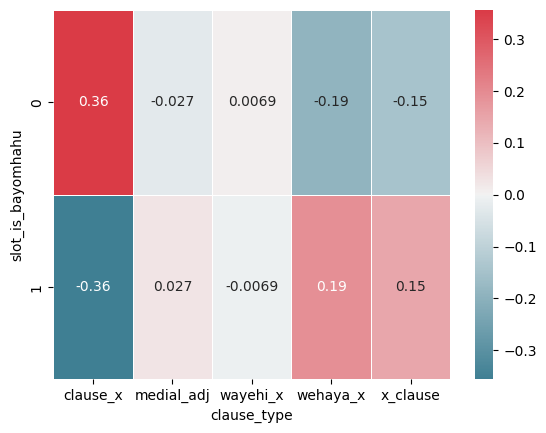

dp2

slot_is_bayomhahu,0,1
clause_type,,
clause_x,0.019576,-0.019576
medial_adj,-0.013061,0.013061
wayehi_x,0.003083,-0.003083
wehaya_x,-0.289573,0.289573
x_clause,-0.009543,0.009543


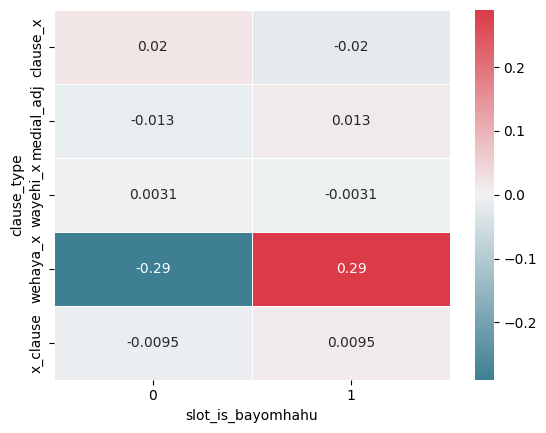

In [83]:
bayomhahu_test = run_analysis(
    df=df,
    index=['slot_is_bayomhahu'],
    columns=['clause_type'],
)

In [84]:
# apply the fisher-yates test to validate that the ΔP scores are
# statistically significant

p_values, odds_ratios = apply_fishers(bayomhahu_test['pivot'], 0, 1, logtransform=False)

In [85]:
p_values

,clause_x,medial_adj,wayehi_x,wehaya_x,x_clause
0,9.072090e-18,-0.047993,1.0,-6.881100e-31,-0.000079
1,-9.072090e-18,0.047993,-1.0,6.881100e-31,0.000079


In [86]:
odds_ratios

,clause_x,medial_adj,wayehi_x,wehaya_x,x_clause
0,4.741917,0.419714,1.449960,0.019143,0.457077
1,0.210885,2.382577,0.689674,52.237946,2.187815


In [87]:
bayomhahu_test['pivot'].to_clipboard()

In [88]:
bayomhahu_test['pivot'].loc[1].sum()

128

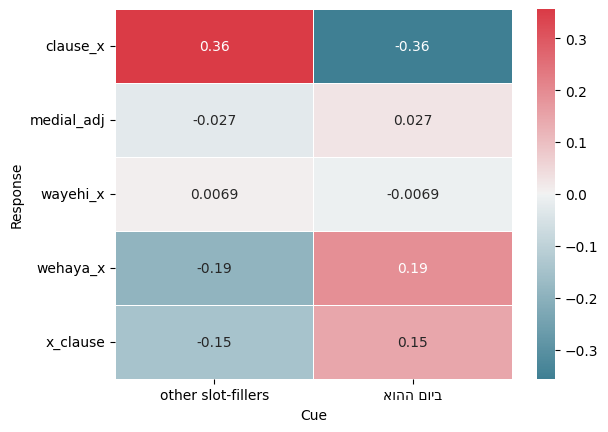

In [89]:
fig, ax = plt.subplots()

heatmap(
    bayomhahu_test['dp1'].T,
    square=False,
    annot=True,
)

ax.set_xlabel('Cue')
ax.set_xticklabels([
    'other slot-fillers',
    algorithm.get_display('ביום ההוא')
], rotation=0)

ax.set_ylabel('Response')
ax.set_yticklabels(
    ax.get_yticklabels(),
    rotation=0,
)

if EXPORT_NEW_PLOTS:
    plt.savefig(
        format_plot_fname('cl_bywm_dp1'),
        bbox_inches='tight',
        format='pdf',
    )

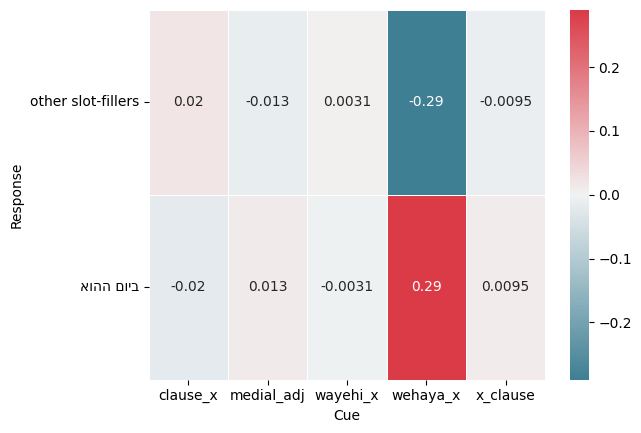

In [90]:
fig, ax = plt.subplots()

heatmap(
    bayomhahu_test['dp2'].T,
    square=False,
    annot=True,
)

ax.set_xlabel('Cue')
ax.set_yticklabels([
    'other slot-fillers',
    algorithm.get_display('ביום ההוא')
], rotation=0)
ax.set_ylabel('Response')

if EXPORT_NEW_PLOTS:
    plt.savefig(
        format_plot_fname('cl_bywm_dp2'),
        bbox_inches='tight',
        format='pdf',
    )

## (function x cl_type associations)

Is the preferences of בַּיּוֹם הַהוּא just a byproduct of time adverbial preferences?

In [91]:
function_cl_test = run_analysis(
    df=df[
        (df.slot_is_PP == 1)
        & (df.slot_is_B == 0)
        & (df.slot_is_bayomhahu == 0)
        & (df.slot_is_def_appo == 0)
    ],
    index=['xphrase_function'],
    columns=['clause_type'],
    show=False,
)

In [92]:
function_cl_test['pivot'].loc['Time'].sum()

216.0

In [93]:
function_cl_test['pivot']

clause_type,clause_x,medial_adj,wayehi_x,wehaya_x,x_clause
xphrase_function,,,,,
Adju,722.0,98.0,1.0,4.0,194.0
Cmpl,2934.0,0.0,5.0,8.0,331.0
Loca,99.0,9.0,0.0,2.0,18.0
Objc,1339.0,0.0,0.0,0.0,239.0
Subj,5.0,0.0,0.0,0.0,5.0
Time,108.0,7.0,56.0,3.0,42.0


In [94]:
function_cl_test['dp1']

clause_type,clause_x,medial_adj,wayehi_x,wehaya_x,x_clause
xphrase_function,,,,,
Adju,-0.152307,0.093102,-0.010727,0.001430,0.068502
Cmpl,0.124811,-0.038631,-0.017790,-0.000609,-0.067780
Loca,-0.063802,0.053102,-0.010162,0.013166,0.007696
Objc,0.016893,-0.024511,-0.013330,-0.003655,0.024603
Subj,-0.336469,-0.018331,-0.009969,-0.002734,0.367503
Time,-0.347996,0.014613,0.258261,0.011561,0.063561


In [95]:
function_cl_test['dp2']

xphrase_function,Adju,Cmpl,Loca,Objc,Subj,Time
clause_type,,,,,,
clause_x,-0.151947,0.226877,-0.009363,0.023299,-0.003932,-0.084934
medial_adj,0.709036,-0.536059,0.059487,-0.258054,-0.001635,0.027225
wayehi_x,-0.148943,-0.450083,-0.020756,-0.255878,-0.001622,0.877281
wehaya_x,0.071901,-0.055812,0.097364,-0.254024,-0.001610,0.142182
x_clause,0.081239,-0.146465,0.001343,0.040336,0.005105,0.018441


In [96]:
function_cl_test_fishers, function_cl_test_fishers_odds = apply_fishers(function_cl_test['pivot'], 0, 1, logtransform=False)

function_cl_test_fishers

,clause_x,medial_adj,wayehi_x,wehaya_x,x_clause
Adju,-1.611616e-29,1.506778e-61,-3.814051e-04,0.505677,1.852331e-08
Cmpl,1.606980e-40,-3.193916e-38,-7.754268e-14,-0.808795,-4.396226e-15
Loca,-6.918096e-02,5.182459e-04,-6.396644e-01,0.046593,7.923968e-01
Objc,1.249899e-01,-3.519395e-15,-2.134827e-08,-0.010320,1.446137e-02
Subj,-1.439594e-02,-1.000000e+00,-1.000000e+00,-1.000000,5.828652e-03
Time,-1.842455e-31,1.174479e-01,4.668207e-78,0.019519,1.039952e-02


In [97]:
function_cl_test_fishers_odds

,clause_x,medial_adj,wayehi_x,wehaya_x,x_clause
Adju,0.392967,34.542074,0.082917,1.575445,1.694202
Cmpl,2.544087,0.000000,0.077562,0.799728,0.553243
Loca,0.663645,4.318848,0.000000,6.440212,1.067369
Objc,1.134117,0.000000,0.000000,0.000000,1.228565
Subj,0.195502,0.000000,0.000000,0.000000,6.547330
Time,0.179251,1.848679,350.408333,6.035211,1.602857


In [98]:
function_cl_test['prop2']

xphrase_function,Adju,Cmpl,Loca,Objc,Subj,Time
clause_type,,,,,,
clause_x,0.138659,0.563472,0.019013,0.257154,0.000960,0.020741
medial_adj,0.859649,0.000000,0.078947,0.000000,0.000000,0.061404
wayehi_x,0.016129,0.080645,0.000000,0.000000,0.000000,0.903226
wehaya_x,0.235294,0.470588,0.117647,0.000000,0.000000,0.176471
x_clause,0.234017,0.399276,0.021713,0.288299,0.006031,0.050663


In [99]:
df[
    (df.xphrase_function == 'Subj')
    & (df.clause_type == 'wayehi_x')
]

,cl_node,ref,book,cl_text,target_ph,clause_type,genre,verse_text,verb_text,verb_lex,...,cl_front,slot_prep,slot_is_PP,slot_is_bayomhahu,slot_is_B,slot_is_BH,slot_is_def_appo,slot_def_appo_head_lex,slot_def_appo_appo_pdp,slot_def_appo_appo_lex
20349,427702,Genesis 2:7,Genesis,וַֽיְהִ֥י הָֽאָדָ֖ם לְנֶ֥פֶשׁ חַיָּֽה׃,הָֽאָדָ֖ם,wayehi_x,prose,וַיִּיצֶר֩ יְהוָ֨ה אֱלֹהִ֜ים אֶת־הָֽאָדָ֗ם עָפ...,יְהִ֥י,HJH[,...,W,?,0,0,0,0,0,NaN,NaN,NaN
20354,428160,Genesis 7:12,Genesis,וַֽיְהִ֥י הַגֶּ֖שֶׁם עַל־הָאָ֑רֶץ אַרְבָּעִ֣ים...,הַגֶּ֖שֶׁם,wayehi_x,prose,וַֽיְהִ֥י הַגֶּ֖שֶׁם עַל־הָאָ֑רֶץ אַרְבָּעִ֣ים...,יְהִ֥י,HJH[,...,W,?,0,0,0,0,0,NaN,NaN,NaN
20355,428170,Genesis 7:17,Genesis,וַֽיְהִ֧י הַמַּבּ֛וּל אַרְבָּעִ֥ים יֹ֖ום עַל־ה...,הַמַּבּ֛וּל,wayehi_x,prose,וַֽיְהִ֧י הַמַּבּ֛וּל אַרְבָּעִ֥ים יֹ֖ום עַל־ה...,יְהִ֧י,HJH[,...,W,?,0,0,0,0,0,NaN,NaN,NaN
20358,428405,Genesis 11:1,Genesis,וַֽיְהִ֥י כָל־הָאָ֖רֶץ שָׂפָ֣ה אֶחָ֑ת וּדְבָרִ...,כָל־הָאָ֖רֶץ,wayehi_x,prose,וַֽיְהִ֥י כָל־הָאָ֖רֶץ שָׂפָ֣ה אֶחָ֑ת וּדְבָרִ...,יְהִ֥י,HJH[,...,W,?,0,0,0,0,0,NaN,NaN,NaN
20360,428772,Genesis 15:12,Genesis,וַיְהִ֤י הַשֶּׁ֨מֶשׁ֙,הַשֶּׁ֨מֶשׁ֙,wayehi_x,prose,וַיְהִ֤י הַשֶּׁ֨מֶשׁ֙ לָבֹ֔וא וְתַרְדֵּמָ֖ה נָ...,יְהִ֤י,HJH[,...,W,?,0,0,0,0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20651,489372,Zechariah 7:4,Zechariah,וַיְהִ֛י דְּבַר־יְהוָ֥ה צְבָאֹ֖ות אֵלַ֥י,דְּבַר־יְהוָ֥ה צְבָאֹ֖ות,wayehi_x,prophetic,וַיְהִ֛י דְּבַר־יְהוָ֥ה צְבָאֹ֖ות אֵלַ֥י לֵאמֹ...,יְהִ֛י,HJH[,...,W,?,0,0,0,0,0,NaN,NaN,NaN
20652,489390,Zechariah 7:8,Zechariah,וַֽיְהִי֙ דְּבַר־יְהוָ֔ה אֶל־זְכַרְיָ֖ה,דְּבַר־יְהוָ֔ה,wayehi_x,prophetic,וַֽיְהִי֙ דְּבַר־יְהוָ֔ה אֶל־זְכַרְיָ֖ה לֵאמֹֽר׃,יְהִי֙,HJH[,...,W,?,0,0,0,0,0,NaN,NaN,NaN
20653,489407,Zechariah 7:12,Zechariah,וַֽיְהִי֙ קֶ֣צֶף גָּדֹ֔ול מֵאֵ֖ת יְהוָ֥ה צְבָא...,קֶ֣צֶף גָּדֹ֔ול,wayehi_x,prophetic,וְלִבָּ֞ם שָׂ֣מוּ שָׁמִ֗יר מִ֠שְּׁמֹועַ אֶת־הַ...,יְהִי֙,HJH[,...,W,?,0,0,0,0,0,NaN,NaN,NaN
20654,489418,Zechariah 8:1,Zechariah,וַיְהִ֛י דְּבַר־יְהוָ֥ה צְבָאֹ֖ות,דְּבַר־יְהוָ֥ה צְבָאֹ֖ות,wayehi_x,prophetic,וַיְהִ֛י דְּבַר־יְהוָ֥ה צְבָאֹ֖ות לֵאמֹֽר׃,יְהִ֛י,HJH[,...,W,?,0,0,0,0,0,NaN,NaN,NaN


## (time (ב (NP)))

In [100]:
time_b_np = run_analysis(
    df=df[
        (df.slot_is_bayomhahu == 0)
        & (df.slot_is_def_appo == 0)
    ],
    index=['slot_is_B', 'xphrase_function'],
    columns=['clause_type'],
    show=False,
)

In [101]:
time_b_np['pivot'].loc[(1, 'Time')].sum()

259.0

In [102]:
time_b_np['pivot']

clause_type                 clause_x  medial_adj  wayehi_x  wehaya_x  x_clause
slot_is_B xphrase_function                                                    
0         Adju                 745.0       100.0       1.0       4.0     201.0
          Cmpl                3159.0         0.0       5.0       8.0     337.0
          Loca                 121.0        11.0       0.0       2.0      21.0
          Objc                1856.0         0.0       0.0       0.0     506.0
          Subj                1548.0         0.0     133.0      28.0     664.0
          Time                 272.0        47.0      62.0       3.0     108.0
1         Adju                 408.0        64.0       1.0       1.0     180.0
          Cmpl                1073.0         0.0       5.0       1.0     150.0
          Loca                 227.0        23.0       1.0       1.0      17.0
          Time                 139.0         7.0      31.0       9.0      73.0

In [103]:
time_b_np['dp1'].loc[(1, 'Time')]

clause_type
clause_x     -0.241310
medial_adj    0.006769
wayehi_x      0.102493
wehaya_x      0.030780
x_clause      0.101268
Name: (1, Time), dtype: float64

## (time (ב (def_appo)))

In [104]:
time_b_def_appo = run_analysis(
    df=df[df.slot_is_bayomhahu == 0],
    index=['slot_is_def_appo', 'slot_prep', 'xphrase_function'],
    columns=['clause_type'],
    show=False,
)

In [105]:
time_b_def_appo['pivot'].loc[(1, 'B', 'Time')].sum()

129.0

In [106]:
time_b_def_appo['pivot']

clause_type                                  clause_x  medial_adj  wayehi_x  \
slot_is_def_appo slot_prep xphrase_function                                   
0                ?         Adju                1153.0       164.0       2.0   
                           Cmpl                4232.0         0.0      10.0   
                           Loca                 348.0        34.0       1.0   
                           Objc                1856.0         0.0       0.0   
                           Subj                1548.0         0.0     133.0   
                           Time                 411.0        54.0      93.0   
1                <D        Loca                   0.0         1.0       0.0   
                           Time                  36.0         1.0       0.0   
                 <L        Adju                   3.0         0.0       0.0   
                           Cmpl                   8.0         0.0       0.0   
                           Loca                   1.0         0.0       0.0   
                 <M        Cmpl                   2.0         0.0       0.0   
                 >L        Cmpl                  29.0         0.0       0.0   
                 >T        Objc                  70.0         0.0       0.0   
                           Subj                   2.0         0.0       0.0   
                 >T==      Adju                   0.0         1.0       0.0   
                 >XR/      Adju                   0.0         0.0       0.0   
                           Cmpl                   1.0         0.0       0.0   
                           Time                   1.0         0.0       8.0   
                 >YL/      Cmpl                   1.0         0.0       0.0   
                 B         Adju                   2.0         0.0       1.0   
                           Cmpl                  21.0         0.0       0.0   
                           Loca                   9.0         2.0       0.0   
                           Time                  53.0         1.0      37.0   
                 B<D/      Adju                   1.0         0.0       0.0   
                           Cmpl                   1.0         0.0       0.0   
                 BJN/      Adju                   1.0         0.0       0.0   
                           Cmpl                   1.0         0.0       0.0   
                 K         Adju                  11.0         0.0       0.0   
                           Cmpl                   2.0         0.0       0.0   
                           Time                   2.0         0.0       1.0   
                 L         Cmpl                  12.0         0.0       0.0   
                           Time                   3.0         0.0       0.0   
                 MN        Adju                   0.0         0.0       0.0   
                           Cmpl                   4.0         0.0       0.0   
                           Time                   0.0         0.0       1.0   

clause_type                                  wehaya_x  x_clause  
slot_is_def_appo slot_prep xphrase_function                      
0                ?         Adju                   5.0     381.0  
                           Cmpl                   9.0     487.0  
                           Loca                   3.0      38.0  
                           Objc                   0.0     506.0  
                           Subj                  28.0     664.0  
                           Time                  12.0     181.0  
1                <D        Loca                   0.0       0.0  
                           Time                   0.0       1.0  
                 <L        Adju                   0.0       0.0  
                           Cmpl                   0.0       0.0  
                           Loca                   0.0       0.0  
                 <M        Cmpl                   0.0       0.0  
                 >L        Cmpl                   0.0       4.0  
       

In [107]:
time_b_def_appo['dp1'].loc[(1, 'B', 'Time')]

clause_type
clause_x     -0.362983
medial_adj   -0.012600
wayehi_x      0.267024
wehaya_x      0.010990
x_clause      0.097568
Name: (1, B, Time), dtype: float64

## Compare across clauses

In [125]:
B = 'ב'
bayom_ha_hu_txt = algorithm.get_display(
    'ביום ההוא'
)

columns = [
    '(adju)',
    '(cmpl)',
    '(loca)',
    '(objc)',
    '(subj)',
    '(time (PP))',
    f'(time ({B} (NP)))',
    f'(time ({B} (def. apposition)))',
    f'(time ({bayom_ha_hu_txt}))'
]

index = [
    'clause x',
    'medial adj.',
    'wayehi x',
    'wehaya x',
    'x clause',
]

compare_df_dp = pd.concat([
    function_cl_test['dp1'].loc['Adju'],
    function_cl_test['dp1'].loc['Cmpl'],
    function_cl_test['dp1'].loc['Loca'],
    function_cl_test['dp1'].loc['Objc'],
    function_cl_test['dp1'].loc['Subj'],
    function_cl_test['dp1'].loc['Time'],
    time_b_np['dp1'].loc[(1, 'Time')],
    time_b_def_appo['dp1'].loc[(1, 'B', 'Time')],
    bayomhahu_test['dp1'].loc[1],
], axis=1)

compare_df_dp.columns = columns

compare_df_dp = compare_df_dp.T

In [130]:
compare_df_dp

clause_type,clause_x,medial_adj,wayehi_x,wehaya_x,x_clause
(adju),-0.152307,0.093102,-0.010727,0.001430,0.068502
(cmpl),0.124811,-0.038631,-0.017790,-0.000609,-0.067780
(loca),-0.063802,0.053102,-0.010162,0.013166,0.007696
(objc),0.016893,-0.024511,-0.013330,-0.003655,0.024603
(subj),-0.336469,-0.018331,-0.009969,-0.002734,0.367503
(time (PP)),-0.347996,0.014613,0.258261,0.011561,0.063561
(time (ב (NP))),-0.241310,0.006769,0.102493,0.030780,0.101268
(time (ב (def. apposition))),-0.362983,-0.012600,0.267024,0.010990,0.097568
(time (אוהה םויב)),-0.356103,0.026651,-0.006872,0.190688,0.145637


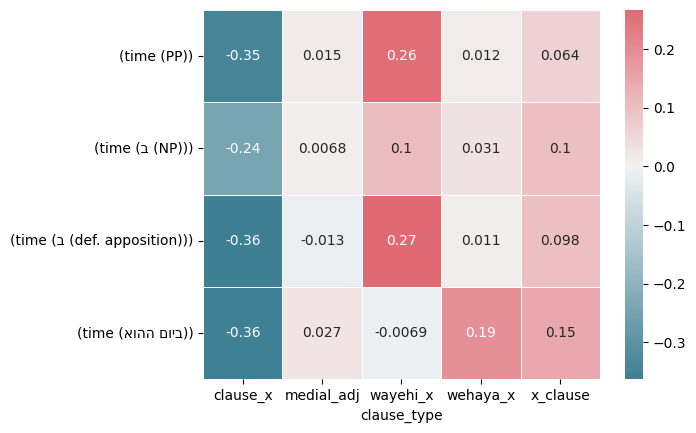

In [135]:
heatmap(
    compare_df_dp.loc['(time (PP))':, :],
    square=False,
    annot=True,
)

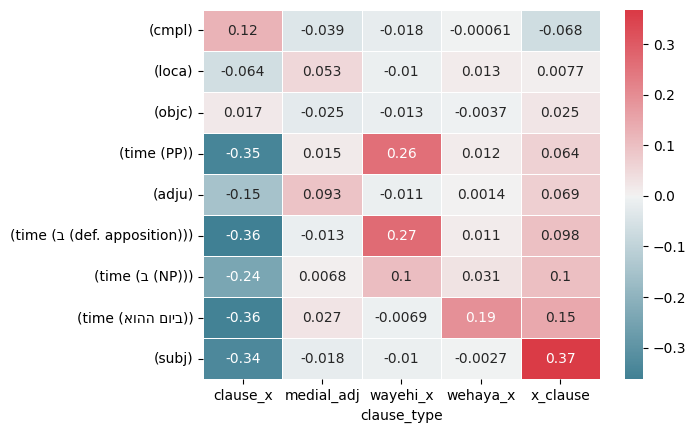

In [129]:
heatmap(
    compare_df_dp.sort_values(by='x_clause'),
    square=False,
    annot=True,
)

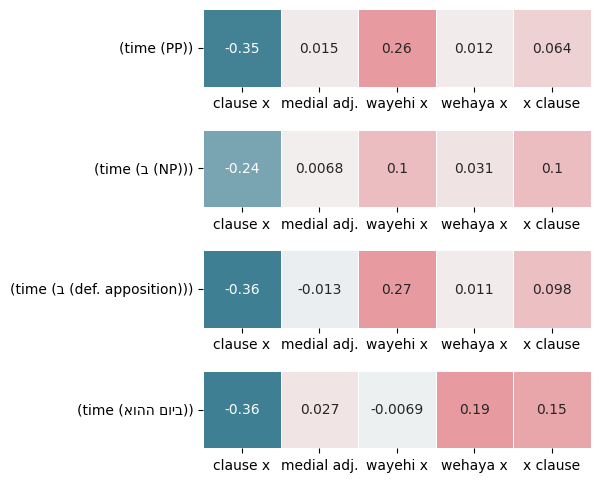

In [138]:
cl_types = [
    'clause x',
    'medial adj.',
    'wayehi x',
    'wehaya x',
    'x clause',
]


fig, axs = plt.subplots(
    nrows=4,
    ncols=1,
    figsize=(5, 6)
)

axs = axs.ravel()
datasets = [
    function_cl_test['dp1'].loc['Time'],
    time_b_np['dp1'].loc[(1, 'Time')],
    time_b_def_appo['dp1'].loc[(1, 'B', 'Time')],
    bayomhahu_test['dp1'].loc[1],
]

datasets = zip(columns[5:], datasets)

position = 0
for ax, dataset in zip(axs, datasets):
    
    cbar = False
    yticklabels = []
    if position == 0:
        yticklabels = cl_types
    elif position == 3:
        cbar = True
        
    
    title, data = dataset
    heatmap(
        pd.DataFrame(data).T,
        annot=True,
        ax=ax,
        vmin=-0.36,
        vmax=0.17,
        cbar=False,
    )
    ax.set_xlabel('')
    ax.set_xticklabels(cl_types, rotation=0)
    ax.set_yticklabels([title], rotation=0)
    ax.set_ylabel('')
    position += 1


if EXPORT_NEW_PLOTS:
    plt.savefig(
        format_plot_fname('cl_type_compare_dp'),
        bbox_inches='tight',
        format='pdf',
    )

# Excursus: With Verb Forms

pivot

clause_type       clause_x                 medial_adj        wayehi_x  \
verb_type             impf    perf    wayq       impf   perf     wayq   
slot_is_bayomhahu                                                       
0                   3234.0  6055.0  5787.0      193.0  288.0    343.0   
1                      4.0    26.0    29.0        0.0    7.0      2.0   

clause_type       wehaya_x x_clause          
verb_type             perf     impf    perf  
slot_is_bayomhahu                            
0                     87.0   2803.0  1875.0  
1                     25.0     39.0     9.0

prop1

clause_type        clause_x                     medial_adj            \
verb_type              impf      perf      wayq       impf      perf   
slot_is_bayomhahu                                                      
0                  0.156496  0.293008  0.280039   0.009339  0.013937   
1                  0.028369  0.184397  0.205674   0.000000  0.049645   

clause_type        wayehi_x  wehaya_x  x_clause            
verb_type              wayq      perf      impf      perf  
slot_is_bayomhahu                                          
0                  0.016598  0.004210  0.135640  0.090733  
1                  0.014184  0.177305  0.276596  0.063830

prop2

slot_is_bayomhahu             0         1
clause_type verb_type                    
clause_x    impf       0.998765  0.001235
            perf       0.995724  0.004276
            wayq       0.995014  0.004986
medial_adj  impf       1.000000  0.000000
            perf       0.976271  0.023729
wayehi_x    wayq       0.994203  0.005797
wehaya_x    perf       0.776786  0.223214
x_clause    impf       0.986277  0.013723
            perf       0.995223  0.004777

dp1

clause_type        clause_x                    medial_adj            wayehi_x  \
verb_type              impf     perf      wayq       impf      perf      wayq   
slot_is_bayomhahu                                                               
0                  0.128128  0.10861  0.074365   0.009339 -0.035709  0.002414   
1                 -0.128128 -0.10861 -0.074365  -0.009339  0.035709 -0.002414   

clause_type        wehaya_x  x_clause            
verb_type              perf      impf      perf  
slot_is_bayomhahu                                
0                 -0.173095 -0.140956  0.026903  
1                  0.173095  0.140956 -0.026903

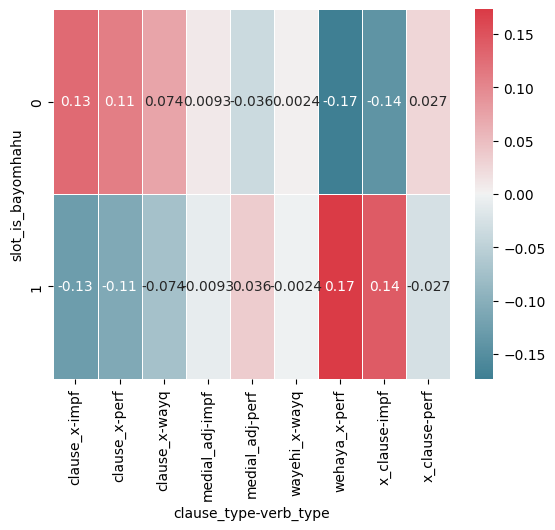

dp2

slot_is_bayomhahu             0         1
clause_type verb_type                    
clause_x    impf       0.006563 -0.006563
            perf       0.003534 -0.003534
            wayq       0.002485 -0.002485
medial_adj  impf       0.006840 -0.006840
            perf      -0.017196  0.017196
wayehi_x    wayq       0.000996 -0.000996
wehaya_x    perf      -0.217609  0.217609
x_clause    impf      -0.008045  0.008045
            perf       0.002199 -0.002199

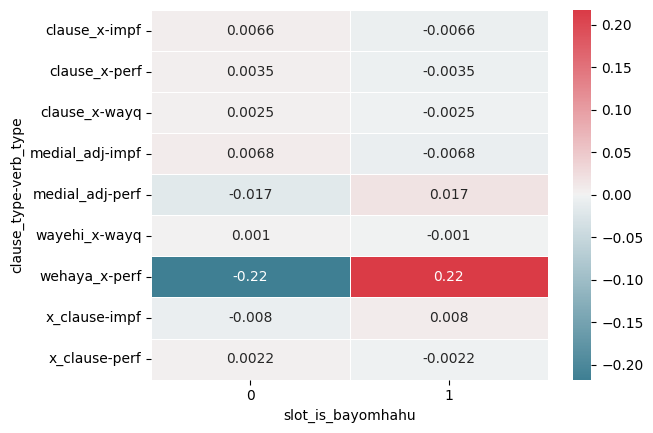

In [718]:
bayomhahu_verb_test = run_analysis(
    df=df,
    index=['slot_is_bayomhahu'],
    columns=['clause_type', 'verb_type'],
)

pivot

clause_type      clause_x                 medial_adj        wayehi_x wehaya_x  \
verb_type            impf    perf    wayq       impf   perf     wayq     perf   
xphrase_function                                                                
Adju                537.0   859.0   618.0      132.0  201.0      4.0      6.0   
Cmpl               1365.0  2462.0  2655.0        0.0    0.0     11.0     16.0   
Loca                101.0   267.0   229.0       24.0   36.0      1.0      3.0   
Objc                580.0  1214.0  1201.0        0.0    0.0      0.0      0.0   
Subj                460.0   961.0   790.0        0.0    0.0    163.0     44.0   
Time                195.0   318.0   323.0       37.0   58.0    166.0     43.0   

clause_type      x_clause         
verb_type            impf   perf  
xphrase_function                  
Adju                544.0  291.0  
Cmpl                704.0  357.0  
Loca                 68.0   47.0  
Objc                559.0  415.0  
Subj                687.0  569.0  
Time                280.0  205.0

prop1

clause_type       clause_x                     medial_adj            wayehi_x  \
verb_type             impf      perf      wayq       impf      perf      wayq   
xphrase_function                                                                
Adju              0.168233  0.269110  0.193609   0.041353  0.062970  0.001253   
Cmpl              0.180317  0.325231  0.350727   0.000000  0.000000  0.001453   
Loca              0.130155  0.344072  0.295103   0.030928  0.046392  0.001289   
Objc              0.146133  0.305870  0.302595   0.000000  0.000000  0.000000   
Subj              0.125204  0.261568  0.215024   0.000000  0.000000  0.044366   
Time              0.120000  0.195692  0.198769   0.022769  0.035692  0.102154   

clause_type       wehaya_x  x_clause            
verb_type             perf      impf      perf  
xphrase_function                                
Adju              0.001880  0.170426  0.091165  
Cmpl              0.002114  0.092999  0.047160  
Loca              0.003866  0.087629  0.060567  
Objc              0.000000  0.140842  0.104560  
Subj              0.011976  0.186990  0.154872  
Time              0.026462  0.172308  0.126154

prop2

xphrase_function           Adju      Cmpl      Loca      Objc      Subj  \
clause_type verb_type                                                     
clause_x    impf       0.165843  0.421557  0.031192  0.179123  0.142063   
            perf       0.141260  0.404868  0.043907  0.199638  0.158033   
            wayq       0.106259  0.456499  0.039374  0.206499  0.135832   
medial_adj  impf       0.683938  0.000000  0.124352  0.000000  0.000000   
            perf       0.681356  0.000000  0.122034  0.000000  0.000000   
wayehi_x    wayq       0.011594  0.031884  0.002899  0.000000  0.472464   
wehaya_x    perf       0.053571  0.142857  0.026786  0.000000  0.392857   
x_clause    impf       0.191414  0.247713  0.023927  0.196692  0.241731   
            perf       0.154459  0.189490  0.024947  0.220276  0.302017   

xphrase_function           Time  
clause_type verb_type            
clause_x    impf       0.060222  
            perf       0.052294  
            wayq       0.055536  
medial_adj  impf       0.191710  
            perf       0.196610  
wayehi_x    wayq       0.481159  
wehaya_x    perf       0.383929  
x_clause    impf       0.098522  
            perf       0.108811

dp1

clause_type       clause_x                     medial_adj            wayehi_x  \
verb_type             impf      perf      wayq       impf      perf      wayq   
xphrase_function                                                                
Adju              0.014889 -0.027358 -0.101497   0.037890  0.057633 -0.018106   
Cmpl              0.038809  0.051810  0.111908  -0.014581 -0.022288 -0.023781   
Loca             -0.026460  0.053808  0.016171   0.022490  0.033461 -0.015886   
Objc             -0.011734  0.016805  0.028496  -0.011463 -0.017521 -0.020491   
Subj             -0.036949 -0.037288 -0.078345  -0.011265 -0.017219  0.033742   
Time             -0.038647 -0.104761 -0.087608   0.014636  0.023336  0.092822   

clause_type       wehaya_x  x_clause            
verb_type             perf      impf      perf  
xphrase_function                                
Adju             -0.004138  0.039962  0.000726  
Cmpl             -0.005139 -0.068530 -0.068207  
Loca             -0.001576 -0.050863 -0.031145  
Objc             -0.006652  0.005247  0.017312  
Subj              0.008007  0.061202  0.078115  
Time              0.022864  0.038738  0.038619

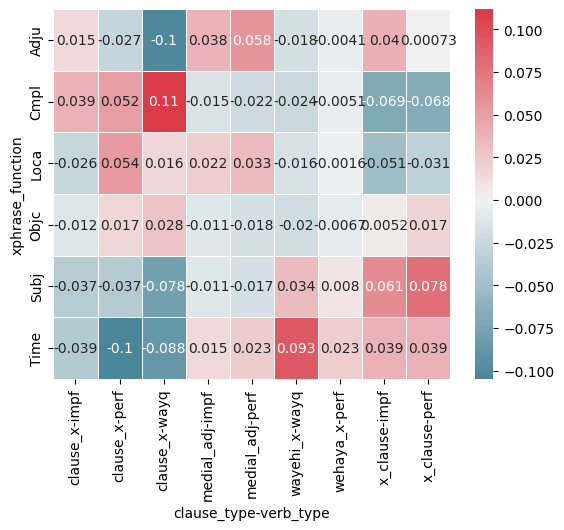

dp2

xphrase_function           Adju      Cmpl      Loca      Objc      Subj  \
clause_type verb_type                                                     
clause_x    impf       0.014716  0.068358 -0.007230 -0.013785 -0.040883   
            perf      -0.017178  0.057975  0.009340  0.012541 -0.026211   
            wayq      -0.065456  0.128614  0.002883  0.021843 -0.056563   
medial_adj  impf       0.535488 -0.367244  0.087870 -0.192548 -0.178237   
            perf       0.535532 -0.369070  0.085956 -0.193506 -0.179123   
wayehi_x    wayq      -0.144214 -0.337550 -0.034978 -0.193979  0.300869   
wehaya_x    perf      -0.100386 -0.222176 -0.010568 -0.191795  0.217444   
x_clause    impf       0.044009 -0.134496 -0.015485  0.006868  0.075454   
            perf       0.001145 -0.191706 -0.013580  0.032452  0.137922   

xphrase_function           Time  
clause_type verb_type            
clause_x    impf      -0.021176  
            perf      -0.036467  
            wayq      -0.031321  
medial_adj  impf       0.114671  
            perf       0.120212  
wayehi_x    wayq       0.409853  
wehaya_x    perf       0.307481  
x_clause    impf       0.023650  
            perf       0.033766

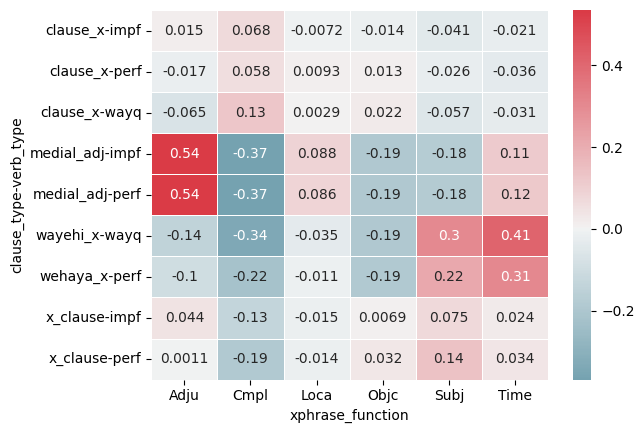

In [719]:
function_cl_test_verb = run_analysis(
    df=df,
    index=['xphrase_function'],
    columns=['clause_type', 'verb_type'],
)

pivot

clause_type                clause_x                 medial_adj         \
verb_type                      impf    perf    wayq       impf   perf   
slot_is_B xphrase_function                                              
0         Adju                322.0   558.0   413.0       91.0  108.0   
          Cmpl                942.0  1757.0  2089.0        0.0    0.0   
          Loca                 29.0    94.0   105.0        6.0   16.0   
          Objc                580.0  1214.0  1201.0        0.0    0.0   
          Subj                460.0   961.0   790.0        0.0    0.0   
          Time                114.0   191.0   178.0       29.0   37.0   
1         Adju                215.0   301.0   205.0       41.0   93.0   
          Cmpl                423.0   705.0   566.0        0.0    0.0   
          Loca                 72.0   173.0   124.0       18.0   20.0   
          Time                 81.0   127.0   145.0        8.0   21.0   

clause_type                wayehi_x wehaya_x x_clause         
verb_type                      wayq     perf     impf   perf  
slot_is_B xphrase_function                                    
0         Adju                  2.0      4.0    306.0  148.0  
          Cmpl                  6.0     14.0    484.0  239.0  
          Loca                  0.0      2.0     30.0   32.0  
          Objc                  0.0      0.0    559.0  415.0  
          Subj                163.0     44.0    687.0  569.0  
          Time                 86.0      4.0    135.0   91.0  
1         Adju                  2.0      2.0    238.0  143.0  
          Cmpl                  5.0      2.0    220.0  118.0  
          Loca                  1.0      1.0     38.0   15.0  
          Time                 80.0     39.0    145.0  114.0

prop1

clause_type                 clause_x                     medial_adj            \
verb_type                       impf      perf      wayq       impf      perf   
slot_is_B xphrase_function                                                      
0         Adju              0.164959  0.285861  0.211578   0.046619  0.055328   
          Cmpl              0.170313  0.317664  0.377689   0.000000  0.000000   
          Loca              0.092357  0.299363  0.334395   0.019108  0.050955   
          Objc              0.146133  0.305870  0.302595   0.000000  0.000000   
          Subj              0.125204  0.261568  0.215024   0.000000  0.000000   
          Time              0.131792  0.220809  0.205780   0.033526  0.042775   
1         Adju              0.173387  0.242742  0.165323   0.033065  0.075000   
          Cmpl              0.207455  0.345758  0.277587   0.000000  0.000000   
          Loca              0.155844  0.374459  0.268398   0.038961  0.043290   
          Time              0.106579  0.167105  0.190789   0.010526  0.027632   

clause_type                 wayehi_x  wehaya_x  x_clause            
verb_type                       wayq      perf      impf      perf  
slot_is_B xphrase_function                                          
0         Adju              0.001025  0.002049  0.156762  0.075820  
          Cmpl              0.001085  0.002531  0.087507  0.043211  
          Loca              0.000000  0.006369  0.095541  0.101911  
          Objc              0.000000  0.000000  0.140842  0.104560  
          Subj              0.044366  0.011976  0.186990  0.154872  
          Time              0.099422  0.004624  0.156069  0.105202  
1         Adju              0.001613  0.001613  0.191935  0.115323  
          Cmpl              0.002452  0.000981  0.107896  0.057872  
          Loca              0.002165  0.002165  0.082251  0.032468  
          Time              0.105263  0.051316  0.190789  0.150000

prop2

slot_is_B                     0                                          \
xphrase_function           Adju      Cmpl      Loca      Objc      Subj   
clause_type verb_type                                                     
clause_x    impf       0.099444  0.290920  0.008956  0.179123  0.142063   
            perf       0.091761  0.288933  0.015458  0.199638  0.158033   
            wayq       0.071011  0.359182  0.018054  0.206499  0.135832   
medial_adj  impf       0.471503  0.000000  0.031088  0.000000  0.000000   
            perf       0.366102  0.000000  0.054237  0.000000  0.000000   
wayehi_x    wayq       0.005797  0.017391  0.000000  0.000000  0.472464   
wehaya_x    perf       0.035714  0.125000  0.017857  0.000000  0.392857   
x_clause    impf       0.107671  0.170303  0.010556  0.196692  0.241731   
            perf       0.078556  0.126858  0.016985  0.220276  0.302017   

slot_is_B                               1                                
xphrase_function           Time      Adju      Cmpl      Loca      Time  
clause_type verb_type                                                    
clause_x    impf       0.035207  0.066399  0.130636  0.022236  0.025015  
            perf       0.031409  0.049498  0.115935  0.028449  0.020885  
            wayq       0.030605  0.035248  0.097318  0.021320  0.024931  
medial_adj  impf       0.150259  0.212435  0.000000  0.093264  0.041451  
            perf       0.125424  0.315254  0.000000  0.067797  0.071186  
wayehi_x    wayq       0.249275  0.005797  0.014493  0.002899  0.231884  
wehaya_x    perf       0.035714  0.017857  0.017857  0.008929  0.348214  
x_clause    impf       0.047502  0.083744  0.077410  0.013371  0.051020  
            perf       0.048301  0.075902  0.062633  0.007962  0.060510

dp1

clause_type                 clause_x                     medial_adj            \
verb_type                       impf      perf      wayq       impf      perf   
slot_is_B xphrase_function                                                      
0         Adju              0.010297 -0.007075 -0.074993   0.041209  0.045410   
          Cmpl              0.020002  0.034587  0.133696  -0.012635 -0.019313   
          Loca             -0.064241  0.007200  0.055701   0.009983  0.037340   
          Objc             -0.011734  0.016805  0.028496  -0.011463 -0.017521   
          Subj             -0.036949 -0.037288 -0.078345  -0.011265 -0.017219   
          Time             -0.024870 -0.074562 -0.076954   0.025302  0.029836   
1         Adju              0.018884 -0.052668 -0.121450   0.025296  0.064676   
          Cmpl              0.057457  0.059297 -0.002159  -0.010284 -0.015719   
          Loca              0.000221  0.084054 -0.011389   0.030359  0.029773   
          Time             -0.050909 -0.129912 -0.092110   0.001298  0.013963   

clause_type                 wayehi_x  wehaya_x  x_clause            
verb_type                       wayq      perf      impf      perf  
slot_is_B xphrase_function                                          
0         Adju             -0.017168 -0.003679  0.022255 -0.016256  
          Cmpl             -0.021108 -0.003885 -0.066863 -0.064481  
          Loca             -0.016836  0.001001 -0.041683  0.011534  
          Objc             -0.020491 -0.006652  0.005247  0.017312  
          Subj              0.033742  0.008007  0.061202  0.078115  
          Time              0.086434 -0.000792  0.020319  0.015287  
1         Adju             -0.015918 -0.004009  0.058847  0.026342  
          Cmpl             -0.015665 -0.004880 -0.031817 -0.036230  
          Loca             -0.014745 -0.003292 -0.055578 -0.059402  
          Time              0.092044  0.047674  0.056249  0.061703

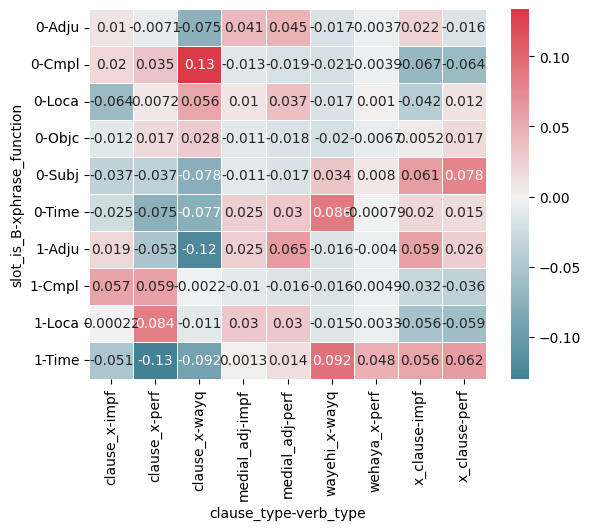

dp2

slot_is_B                     0                                          \
xphrase_function           Adju      Cmpl      Loca      Objc      Subj   
clause_type verb_type                                                     
clause_x    impf       0.006662  0.029707 -0.007267 -0.013785 -0.040883   
            perf      -0.002908  0.032634  0.000517  0.012541 -0.026211   
            wayq      -0.031657  0.129562  0.004111  0.021843 -0.056563   
medial_adj  impf       0.381220 -0.268326  0.016146 -0.192548 -0.178237   
            perf       0.276199 -0.269660  0.039708 -0.193506 -0.179123   
wayehi_x    wayq      -0.089506 -0.252635 -0.015346 -0.193979  0.300869   
wehaya_x    perf      -0.058419 -0.141599  0.002780 -0.191795  0.217444   
x_clause    impf       0.016043 -0.110648 -0.005253  0.006868  0.075454   
            perf      -0.016782 -0.152817  0.002082  0.032452  0.137922   

slot_is_B                               1                                
xphrase_function           Time      Adju      Cmpl      Loca      Time  
clause_type verb_type                                                    
clause_x    impf      -0.007541  0.008054  0.038651  0.000036 -0.013634  
            perf      -0.014363 -0.014271  0.025341  0.008823 -0.022103  
            wayq      -0.015225 -0.033798 -0.000948 -0.001228 -0.016096  
medial_adj  impf       0.109702  0.154268 -0.098918  0.071724  0.004969  
            perf       0.085055  0.259333 -0.099410  0.046247  0.035157  
wayehi_x    wayq       0.211203 -0.054708 -0.084916 -0.019632  0.198650  
wehaya_x    perf      -0.005892 -0.041967 -0.080577 -0.013348  0.313373  
x_clause    impf       0.006865  0.027966 -0.023848 -0.010232  0.016785  
            perf       0.007397  0.017927 -0.038889 -0.015662  0.026369

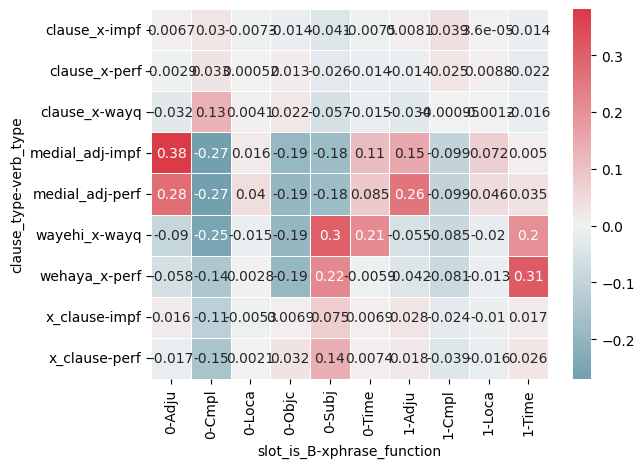

In [720]:
time_b_np_verb = run_analysis(
    df=df,
    index=['slot_is_B', 'xphrase_function'],
    columns=['clause_type', 'verb_type'],
)

# Text Examples

In [824]:
import subprocess 

def copy_to_clipboard(data):
    subprocess.run("pbcopy", universal_newlines=True, input=data)

In [825]:
def get_verse(section):
    node = T.nodeFromSection(section)
    copy_to_clipboard(T.text(node))

## Clause-x

In [826]:
df.columns

Index(['cl_node', 'ref', 'book', 'cl_text', 'target_ph', 'clause_type',
       'verse_text', 'verb_text', 'verb_lex', 'verb_type', 'verb_stem',
       'xphrase_function', 'cl_front', 'slot_prep', 'slot_is_PP',
       'slot_is_bayomhahu', 'slot_is_B', 'slot_is_BH', 'slot_is_def_appo',
       'slot_def_appo_head_lex', 'slot_def_appo_appo_pdp',
       'slot_def_appo_appo_lex'],
      dtype='object')

In [844]:
# df[
#     (df.slot_is_bayomhahu == 1)
#     & (df.clause_type == 'clause_x')
# ]

In [835]:
get_verse(('Exodus', 13, 8))

In [836]:
get_verse(('Joshua', 14, 9))

In [838]:
get_verse(('Leviticus', 27, 23))

In [837]:
get_verse(('1_Samuel', 4, 12))

In [840]:
get_verse(('Jeremiah', 39, 10))

In [841]:
get_verse(('Amos', 8, 3))

In [842]:
get_verse(('Zechariah', 14, 21))

In [843]:
get_verse(('1_Chronicles', 13, 12))

## X-clause

In [846]:
get_verse(('Leviticus', 22, 30))

In [847]:
get_verse(('Joshua', 4, 14))

In [848]:
get_verse(('1_Kings', 8, 64))

In [849]:
get_verse(('Isaiah', 7, 20))

In [850]:
get_verse(('Ezekiel', 20, 6))

In [851]:
get_verse(('Micah',2, 4))

In [852]:
get_verse(('Psalms',146, 4))

In [853]:
get_verse(('Esther', 8, 1))

In [854]:
# df[
#     (df.slot_is_bayomhahu == 1)
#     & (df.clause_type == 'x_clause')
# ]

In [866]:
df[
    (df.slot_is_bayomhahu == 1)
    & (df.clause_type == 'wayehi_x')
][['ref', 'verse_text']].to_clipboard(index=False)

In [872]:
get_verse(('Job', 20, 19))

In [ ]:
כִּֽי־רִ֭צַּץ עָזַ֣ב דַּלִּ֑ים בַּ֥יִת גָּ֝זַ֗ל וְלֹ֣א יִבֶנֵֽהוּ׃ 